<a href="https://colab.research.google.com/github/AndreaDiTrani/Quantum-Optimization-internship/blob/main/JSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i tackle the JSS problem from start to finish via quantum annealing.

At the moment the workflow is:



*   Instance generation
*   QUBO fomrulation with timespan discrimination
*   Pruning
*   Default embedding and compilation
*   Problem solution using quantum annealing on QPU
*   Solution visualization

Next steps are:

*   Fault tolerant IP embedding
*   Data collection for problems pre-characterization
*   Graph visualization



#IMPORTS

In [1]:
!pip install dwave-ocean-sdk
!pip install gurobipy
!pip install pyqubo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 124.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 131.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 119.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import networkx as nx
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import copy
from itertools import product
import pickle

import pyqubo
from pyqubo import Binary, SubH

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go
import dwave.inspector
import minorminer
import dwave_networkx as dnx
import neal

from dwave.embedding import pegasus
from dwave.cloud import Client

import gurobipy as gb
from gurobipy import GRB

In [3]:
from google.colab import drive
drive.mount('/content/drive')

lic_path = '/content/drive/MyDrive/Uni/' #path to gurobi and D-Wave licenses

with open(lic_path + 'gurobi.lic','r') as f:
  lic = f.read()

ls = lic.split('\n')
access_id = ls[3].split('=')[1]
secret = ls[4].split('=')[1]
id = int(ls[5].split('=')[1])

params = {
"WLSACCESSID": access_id,
"WLSSECRET": secret,
"LICENSEID": id,
}
env = gb.Env(params=params)

client_qpu = Client.from_config(lic_path+'dwave.conf')

Mounted at /content/drive
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2381296
Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it


In [4]:
client_qpu.get_solvers()

[BQMSolver(id='hybrid_binary_quadratic_model_version2'),
 DQMSolver(id='hybrid_discrete_quadratic_model_version1'),
 CQMSolver(id='hybrid_constrained_quadratic_model_version1'),
 StructuredSolver(id='Advantage2_prototype1.1'),
 StructuredSolver(id='Advantage_system4.1'),
 StructuredSolver(id='Advantage_system6.2')]

# JSS



In [5]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

  instance = {}
  machine_list = list(range(n_machine))

  for i in range(n_job):
    random.shuffle(machine_list)
    instance[i] = []
    for j in range(n_machine):
      instance[i].append((machine_list[j], random.randint(1,max_duration))) #machine, duration
  instance['timespan'] = timespan

  return instance

In [6]:
def instance_from_file(path, timespan):

  instance = {}
  instance['timespan'] = timespan
  with open(path, 'r') as f:
    lines = f.readlines()

  print([int(x) for x in lines[-1].replace(' \n', '').split('\t')])
  ls = [int(x) for x in lines[0].replace(' \n', '').split('\t')]

  n_jobs = ls[0]
  print(n_jobs)
  n_machines = ls[1]

  for j in range(1,n_jobs+1):
    instance[j-1] = []
    ls = [int(x) for x in lines[j].replace(' \n', '').split('\t')]
    for o in range(n_machines):
      instance[j-1].append([ls[2*o],ls[2*o+1]])
  return instance

## Disjunctive Formulation (ILP)

In [7]:
def ilp_var_dict(instance, model):
  dec_dict = {}
  bin_dict = {}
  slack_dict = {}

  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1

  V = 0
  for j in range(n_jobs):
    for o in range(n_machines):
      V += instance[j][o][1]

  instance['timespan'] = V

  for j in range(n_jobs):
    for m in range(n_machines):
      dec_dict[j,m] = model.addVar(vtype=GRB.INTEGER, name=f'x_{j},{m}')

      #slack variable generation
      s_idx = len(slack_dict)
      slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')
      #model.addConstr(slack_dict[s_idx] <= V, f'slack_{s_idx}')

      model.addConstr(dec_dict[j,m] - slack_dict[s_idx] == 0, f'sign_{j},{m}')

      for k in range(n_jobs):
        bin_dict[j,k,m] = model.addVar(vtype=GRB.BINARY, name=f'z_{m},{j},{k}')

  return dec_dict, bin_dict, slack_dict

In [8]:
def prec_const(instance, model, dec_dict, slack_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1

  for j in range(n_jobs):
    for o in range(1,n_machines):

      m_o = instance[j][o][0] #machine of the o-th operation
      m_o_1 = instance[j][o-1][0] #machine of the (o-1)-th operation

      p_o_1 = instance[j][o-1][1] #duration of the (o-1)-th operation

      s_idx = len(slack_dict)
      slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

      model.addConstr(dec_dict[j,m_o] - dec_dict[j,m_o_1]  - slack_dict[s_idx] == p_o_1, f'prec_{j},{m_o},{m_o_1}')

In [9]:
def disj_const(instance, model, dec_dict, bin_dict, slack_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  V = instance['timespan']

  for j in range(n_jobs):
    for k in range(j+1, n_jobs):
      for m in range(n_machines):

        #search for tasks durations
        for i in range(n_machines):
          if instance[j][i][0] == m:
            p_j = instance[j][i][1]
          if instance[k][i][0] == m:
            p_k = instance[k][i][1]

        s_idx = len(slack_dict)
        slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

        model.addConstr(dec_dict[j,m] - dec_dict[k,m] + V*bin_dict[j,k,m] - p_k - slack_dict[s_idx] == 0, f'disj_1_{j},{k},{m}')

        s_idx = len(slack_dict)
        slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

        model.addConstr(dec_dict[k,m] - dec_dict[j,m] + V*(1-bin_dict[j,k,m]) - p_j - slack_dict[s_idx] == 0 , f'disj_2_{j},{k},{m}')

In [10]:
def makespan_cons(instance, model, dec_dict):
  C = model.addVar(vtype=GRB.INTEGER, name='C')
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1

  for j in range(n_jobs):
    last_machine = instance[j][-1][0]
    p = instance[j][-1][1]

    s_idx = len(slack_dict)
    slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

    model.addConstr(C - dec_dict[j,last_machine] - p - slack_dict[s_idx] == 0, f'makespan_{j}')

  return C

### Graver Basis Extraction

In [530]:
def filter_graver(unencoded_samples):

  rm_list = []

  for i,s1 in enumerate(unencoded_samples):
    for k in range(i+1,len(unencoded_samples)):

      s2 = unencoded_samples[k]

      if ( s1 @ s2 > 0) and all(np.abs(s1) <= np.abs(s2)):

        rm_list.append(k)

    if all(s1 == np.zeros(s1.shape)):
      rm_list.append(i)



  rm_list = set(rm_list)

  return  list(set(range(len(unencoded_samples))) - rm_list)

In [149]:
def build_int_encoding(upper_bound_array, lower_bound_array, n, encoding='bin'):

  #generate lengths based on the chosen encoding
  if encoding == 'bin':
    k_arr = np.ceil(np.log2(upper_bound_array+1-lower_bound_array)).astype(np.int64)
  else:
    k_arr = (upper_bound_array-lower_bound_array).astype(np.int64)

  E = np.zeros((n, np.sum(k_arr)), dtype=np.int64)
  start=0
  for j,k in enumerate(k_arr):
    e = np.zeros(k, dtype=np.int64)
    for i in range(k):

      #apply the selected encoding
      if encoding == 'bin':
        e[i] = 2**i
      else:
        e[i] = 1

    E[j,start:start+k] = e
    start += k


  return E


In [186]:
def build_graver_qubo(A, upper_bound_array, lower_bound_array, encoding='bin'):
  Q_i = A.T @ A
  n = Q_i.shape[0]

  E = build_int_encoding(upper_bound_array, lower_bound_array, n, encoding=encoding)

  graver_qubo = (E.T @ Q_i @ E + np.diag(2*lower_bound_array.T @ Q_i @ E)).astype(np.int64)

  return graver_qubo , lower_bound_array @ Q_i @ lower_bound_array, E


In [424]:
def filter_lower_energies(dec_sampleset, k=3):

  out = {}
  for e in range(k):

    ls = []

    for s in dec_sampleset:
      if s.energy == e:
        ls.append(s)

    out[e] = ls

  return out

In [476]:
def decode_solutions(solutions):

  sampleset = {}

  for k in solutions:

    tmp = {'sample':[], 'energy':[]}

    for s in solutions[k]:

      new_s = np.zeros(len(s.sample))
      for i,x in enumerate(s.sample):
        pos = int(x.split('[')[1].split(']')[0])
        new_s[pos] = s.sample[x]

      tmp['sample'].append(np.array(new_s))
      tmp['energy'].append(s.energy)

    sampleset[k] = tmp

  return sampleset

In [15]:
def unencode_sample(lower, E, X):
  unencoded_sample = lower + E @ X
  return unencoded_sample

In [16]:
def sample_graver_cqm(A, sampler, time_limit):
  Q = A.T @ A

  qm = dimod.QuadraticModel()

  for i in range(Q.shape[0]):
    qm.add_variable('INTEGER', f'x[{i}]', lower_bound = -2,upper_bound =  2)

  #this step is needed to easily obtain the dictionary of the interactions
  X = pyqubo.Array.create('x', shape=Q.shape[0], vartype='BINARY')
  exp = X.T @ Q @ X
  m = exp.compile()
  bqm = m.to_qubo()

  qm.add_quadratic_from(bqm[0])

  #convert to CQM (for reasons DWave's solvers can't deal with QM)
  cqm = dimod.ConstrainedQuadraticModel().from_bqm(qm)

  sampleset = sampler.sample_cqm(cqm, time_limit=time_limit)

  return sampleset

In [503]:
def unencode_sampleset(sampleset, lower, E):


  for k in sampleset:
    for i,s in enumerate(sampleset[k]['sample']):
      sampleset[k]['sample'][i] = unencode_sample(lower, E, s)

    sampleset[k]['sample'] = np.array(sampleset[k]['sample'])


## Time-Indexing Formulation(QUBO)

In [ ]:
def qubo_var_dict(instance):
  var_dict = {}

  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  for j in range(n_jobs):
      for o in range(n_machines):
        for t in range(timespan):
          var_dict[(o,j,t)] = pyqubo.Binary(f'x_{o},{j},{t}') #o=order position, j=relative job, t=time
  return var_dict

### Penalties

This function generates penalty relative to the **START ONLY ONCE** constraint.

The mathematical formulation of this constraint is:
$$ \sum_i(\sum_t x_{i,t} -1)^2 $$

And so we have an edge for every pair $x_{i,t}, x_{i,p}$ where $p \neq t$

This kind of edges are orange in the final plots

In [ ]:
def soo_cons(instance, var_dict):
  tot = 0
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  for j in range(n_jobs): #relative job
    for o in range(n_machines): #order position
      part = 0
      for t in range(timespan):
        part += var_dict[o,j,t]
      part = (part - 1)**2
      tot += part
  return tot

This function generates the edges relative to the **OPERATION ORDER** constraint.

The mathematical formulation of this constraint is:

$$ \sum_{ k_{n-1}<i<k_n \atop t+p_i > t'}  x_{i,t}x_{i+1,t'}$$

In [ ]:
def oo_cons(instance, var_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  tot=0
  for job in range(n_jobs):#relative job
    for o in range(n_machines-1): #order position
      task = instance[job][o]
      p = task[1] #duration

      for t in range(timespan):
        t_max = min(t + p, timespan)
        for t_p in range(t_max):

          #m_p = task_p[0]

          tot += var_dict[o,job,t]*var_dict[o+1,job,t_p]
  return tot

This set of functions generates the edges relative to the **ONE AT TIME PER MACHINE** constraint.

The mathematical formulation of this constraint is:
$$\sum_{(i,t,k,t')\in R_m} x_{i,t}x_{k,t'} $$

where $R_m = A_m \cup B_m$

And $A_m = \{(i,t,k,t'): (i,k) \in I_M \times I_M, \\ \qquad \qquad i \neq j,\\ \qquad \qquad 0\leq t,\\ \qquad \qquad t'\leq T,\\ \qquad \qquad 0<t'-t<p_i  \}$

where $I_M$ is the set of all tasks that need the machine M to run.

In [ ]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for o,task in enumerate(instance[job]):
            if task[0] == m:
                I_m.add((o,job))

    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)

    return I_mx

In [ ]:
def A_set(instance, m):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  I_mx = I_set(instance, m)

  A_m = set()

  for e in I_mx: #e = ((o1,j1),(o2,j2))

    job = e[0][1]
    for t in instance[job]:
      if t[0] == m:
        p = t[1] #duration task position i

    for t in range(timespan):
      for t_p in range(timespan):
        if (0<t_p - t) and (t_p-t<p):
          new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
          A_m.add(new_el)
  return A_m

In [ ]:
def B_set(instance, m):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  I_mx = I_set(instance, m)

  B_m = set()

  for e in I_mx:
    job_i = e[0][1]

    for i,t in enumerate(instance[job_i]):
      if t[0] == m:
        p_i = t[1] #duration
        o_i = i

    job_j = e[0][1]

    for i,t in enumerate(instance[job_i]):
      if t[0] == m:
        p_j = t[1] #duration
        o_j = i


    if p_j > 0 and p_i>0:
      for t in range(timespan):
        new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t))
        B_m.add(new_el)

  return B_m

In [ ]:
def otm_cons(instance, var_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']
  edges = []
  tot = 0
  for m in range(n_machines):
      R_m = A_set(instance, m).union(B_set(instance, m))
      for e in R_m:
        tot += var_dict[e[0]]*var_dict[e[1]]
  return tot


###Pruning

Let $I_j$ be the set of indices of tasks that have to run on the machine $j$ then,
if $a,b \in I_j$ are such that:
$$r_a+p_a+p_b+q_b>T$$
where $r_i$ is the sum of the execution time of the tasks preceding $O_i$ and $q_i$ is similarly defined for the tasks that follows $O_i$, those values are called **head and tail** of the task.

Then $O_a$ must be run after $O_b$ and we can update $r_a$ as:
$$r_a = max\{r_a,r_b+p_b\}$$

Thanks to the symmetry of the problem, similar updates can be performed to the tails.

In [ ]:
def simple_pruning(instance,var_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']
  ext_instance = copy.deepcopy(instance) #this extended instance will contain also the head and tail of each operation

  #head and tail comp
  for job in range(n_jobs):
    for t_idx,task in enumerate(instance[job]):
      p_task = task[1]
      m_task = task[0]
      #single job upperbound
      tail = timespan
      for i in range(t_idx, n_machines):
        tail -= instance[job][i][1]

      #single job lowerbuond
      head = 0
      for i in range(t_idx):
        head += instance[job][i][1]

      ext_instance[job][t_idx] += (head,tail)

  tmp_instance = copy.deepcopy(ext_instance)
  ext_instance = tmp_instance

  #node removal
  rm_nodes = []
  for job in range(n_jobs):
    for task in ext_instance[job]:
      for node in var_dict:
        if (node[0] == task[0]) and (node[1] == job) and ((node[2] < task[2] ) or (node[2] > task[3])):
          var_dict[node] = 0

  return var_dict, ext_instance

### Timespan Discrimination

In [ ]:
def timespan_dis(instance, var_dict, K=1, energy_array=[0.5]):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  temp_dict = copy.copy(var_dict)

  tot=0
  for k in range(K):
    for j in range(n_jobs):
      found=False
      for i in range(timespan):
        triplet = (n_machines-1, j, timespan-k-i-1)                             #check the latest moment avaible for the start of the last operation,
        if (triplet in temp_dict and                                            #avaible for the start of the last operation, needed in case of pruning
            type(temp_dict[triplet]) is not int and
            not found):
          tot += energy_array[k]*temp_dict[n_machines-1, j, timespan-k-i-1]
          found = True
          temp_dict[triplet] = 0


  return tot


## Utils

In [ ]:
def draw_solution(solution, instance, formulation='time'):
  cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
  color_array = np.zeros((1,4))
  n_jobs = len(instance)-1

  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)

  y_ticks = []
  n_machines = len(instance[0])
  timespan = instance['timespan']
  for i in range(n_machines):
    y_ticks.append(f'M {i}')

  ax.set_yticks(range(n_machines), labels=y_ticks)

  end = 0
  x_ticks = []
  if formulation == 'time':
    for i,var in enumerate(solution):
      if solution[var] == 1:
        spl = var.split('_')[1].split(',')
        order = int(spl[0])
        job = int(spl[1])
        start = int(spl[2])

        x_ticks.append(start)
        color_array[0] = cmap_nodes(job/n_jobs)

        machine = instance[job][order][0]
        duration = instance[job][order][1]

        if start + duration > end:
          end = start + duration

        bar = ax.barh(machine, width=duration, left=start, color=color_array)
        ax.bar_label(bar, label_type='center', labels=[f'J {job}, O {order}'])

  else:
    for i, var in enumerate(solution):
      var_name = var.VarName
      spl = var_name.split('_')[1].split(',')
      job = int(spl[0])
      machine = int(spl[1])
      start = var.X
      x_ticks.append(start)
      color_array[0] = cmap_nodes(job/n_jobs)

      for o,t in enumerate(instance[job]):
        if t[0] == machine:
          duration = t[1]
          order = o

      if start + duration > end:
          end = start + duration
      bar = ax.barh(machine, width=duration, left=start, color=color_array)
      ax.bar_label(bar, label_type='center', labels=[f'J {job}, O {order}'])

  ax.set_xticks(list(range(0, int(end), int((end)/10))) + [end] )
  #ax.set_xticklabels(range(int(start+duration), int((start+duration)/10)))

In [ ]:
[1,2] + [1]

[1, 2, 1]

# Execution

## Instance generation

In [ ]:
# instance presented in Venturelli's work, here used for testing

instance = {
    0: [(0,2), (1,1), (2,1)],
    1: [(2,2), (0,1), (1,2)],
    2: [(1,1), (0,1), (2,2)],
    'timespan': 6
}

In [ ]:
#generate random instance (machine, job, max duration, timespan)

n_jobs = 7
n_machines = 10
max_duration = 5
timespan = 10

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)

In [ ]:
instance = instance_from_file('/content/ft10.txt', 10)

[1, 85, 0, 13, 2, 61, 6, 7, 8, 64, 9, 76, 5, 47, 3, 52, 4, 90, 7, 45]
10


## Time-Indexing solving

In [ ]:
#pruning

var_dict = qubo_var_dict(instance)
#var_dict, ext_instance = simple_pruning(instance, var_dict)

In [ ]:
#build the model

#add constraints, separating the full hamiltonian in smaller sub-hamiltonians
#helps identifing wich constraint gets violated in case of non feasible solutions
H = SubH(otm_cons(instance, var_dict), 'otm_cons')
H += SubH(soo_cons(instance, var_dict), 'soo_cons')
H += SubH(oo_cons(instance, var_dict), 'oo_cons')
H += SubH(timespan_dis(instance, var_dict, K=5, energy_array=[0.5,0.4,0.3,0.2,0.1]), 'time_discrimination')
model = H.compile()

#generate bqm

bqm = model.to_bqm()

### QPU solving

In [ ]:
#sample on QPU and standard embedding

dw = dwave.system.DWaveSampler(token=client_qpu.token, solver={'topology__type': 'pegasus'})
sampler = dwave.system.EmbeddingComposite(dw)

sampleset = sampler.sample(bqm,
      answer_mode="raw",
      num_reads=4500,
      annealing_time=40)

In [ ]:
#check energy of the best sample
solution = sampleset.first.sample
round(sampleset.first.energy,2)

0.4

## Disjunctive Solving

### Model Building

In [ ]:
model = gb.Model('JSS', env=env)

dec_dict, bin_dict, slack_dict = ilp_var_dict(instance, model)
model.update()

In [ ]:
prec_const(instance, model, dec_dict, slack_dict)
model.update()

In [ ]:
disj_const(instance, model, dec_dict, bin_dict, slack_dict)
model.update()

In [ ]:
C = makespan_cons(instance, model, dec_dict)
model.update()

In [ ]:
model.setObjective(C, GRB.MINIMIZE)
model.update()

### Gurobi solving

In [ ]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 1100 rows, 2201 columns and 4100 nonzeros
Model fingerprint: 0x24b9c814
Variable types: 0 continuous, 2201 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 5e+03]
Presolve removed 100 rows and 1650 columns
Presolve time: 0.01s
Presolved: 1000 rows, 551 columns, 2900 nonzeros
Variable types: 0 continuous, 551 integer (450 binary)

Root relaxation: objective 6.550000e+02, 299 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

In [ ]:
solution = []
for v in model.getVars():
  if 'x_' in v.VarName:
    solution.append(v)

### GAMA algorithm

In [511]:
# test matrix with knwon graver basis

A = np.array([[1,1,1,1],[1,5,10,25]])

In [512]:
# initial upper - lower bounds of variables

upper = np.zeros(4)
lower = np.zeros(4)
for i in range(len(upper)):
  upper[i] = 5
  lower[i] = -9


In [513]:
#build encoding
E = build_int_encoding(upper, lower, 4, encoding='bin')
Q, c = build_graver_qubo(A, upper, lower, encoding='bin')

In [514]:
#BQM generation
X = pyqubo.Array.create('X', shape=Q.shape[0], vartype='BINARY')
exp = X @ Q @ X + c
m = exp.compile()

In [510]:
dw = dwave.system.DWaveSampler(token=client_qpu.token, solver={'topology__type': 'pegasus'})
sampler = dwave.system.EmbeddingComposite(dw)

In [532]:
sampleset = sampler.sample(m.to_bqm(),
      answer_mode="raw",
      num_reads=4500,
      annealing_time=50)

In [533]:
dec_sampleset = m.decode_sampleset(sampleset)

In [534]:
f_solutions = filter_lower_energies(dec_sampleset, k=3)

In [535]:
dec_solutions = decode_solutions(f_solutions)

In [536]:
unencode_sampleset(dec_solutions, lower, E)

In [537]:
tmp = dec_solutions[0]['sample']
tmp

array([[ 5.,  0., -8.,  3.],
       [-5.,  6.,  0., -1.]])

In [538]:
f_idx = filter_graver(dec_solutions[0]['sample'])
dec_solutions[0]['sample'][f_idx]

array([[ 5.,  0., -8.,  3.],
       [-5.,  6.,  0., -1.]])

In [558]:
error_arr =  A @ dec_solutions[1]['sample'].T
print(error_arr)

[[-1.  0.  0.  0. -1.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0. -1.]
 [ 0.  1. -1.  1.  0. -1. -1.  1.  0.  0. -1. -1.  1.  1.  1.  0.]]


## Visualization

### Single solution

In [ ]:
solution

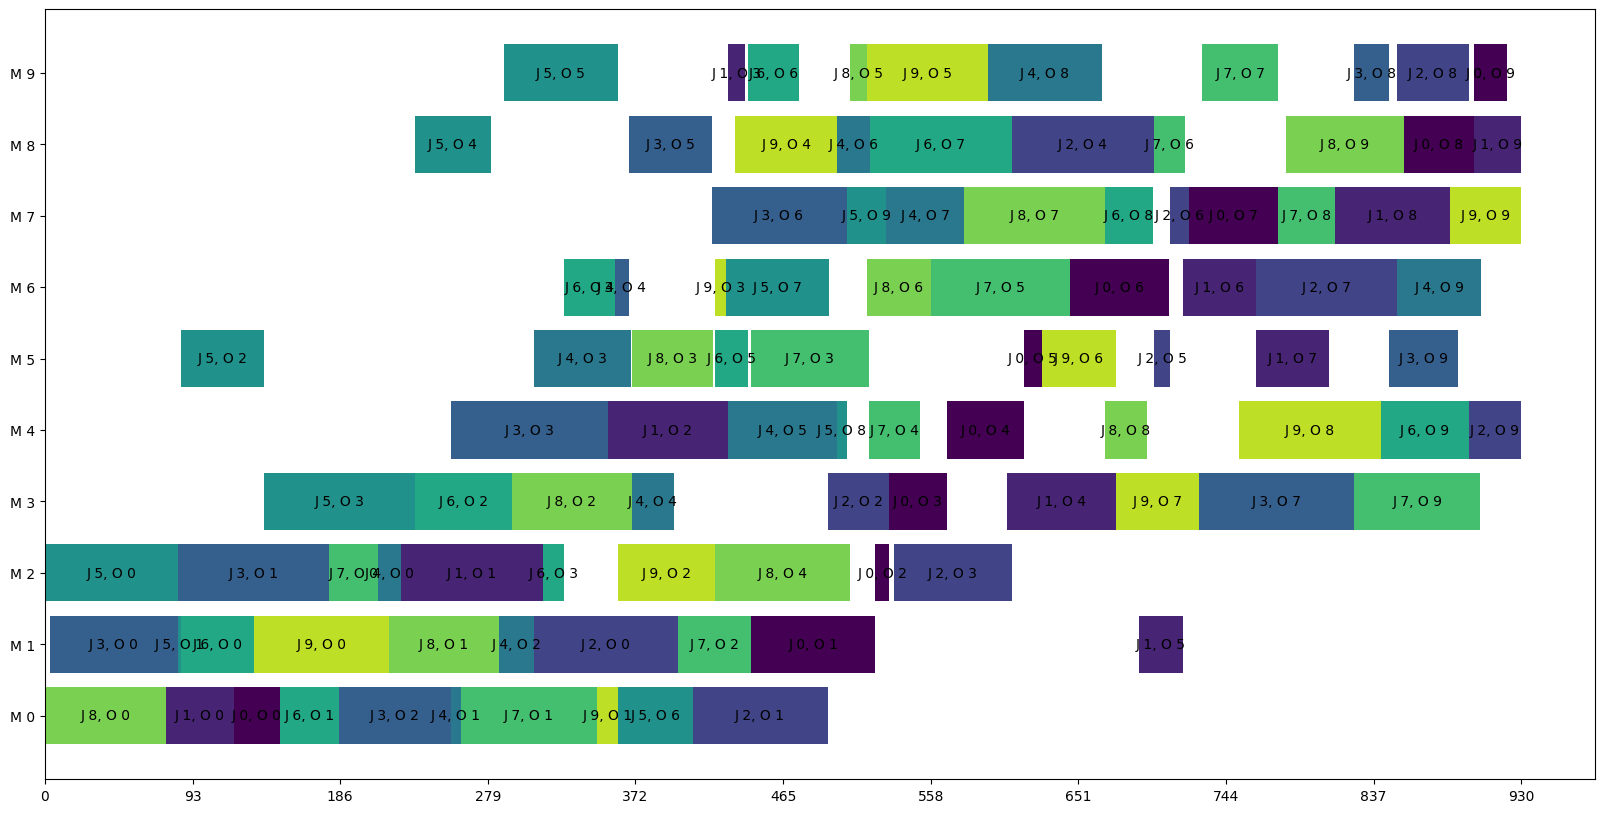

In [ ]:
#draw solution
draw_solution(solution, instance, formulation='disj')

In [ ]:
#check wich constraint gets violated ('time_discrimination' is not a proper  constraint,
#it is a penalty added to longer makespans) ONLY FOR TIME-INDEXING FORMULATION

decoded = model.decode_sample(solution, vartype='BINARY')
decoded.subh

{'otm_cons': 0.0, 'time_discrimination': 0.1, 'oo_cons': 0.0, 'soo_cons': 0.0}